In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import glob, os
from IPython.display import Image
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVR, SVR
from sklearn import metrics
from sklearn.linear_model import LinearRegression,Ridge
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn import tree
import pydotplus
from sklearn.externals.six import StringIO
#path = "C:\\Users\\Mohamed\\MS BGD\\fil_rouge_lepoint\\Predictions éléctions\\PRESIDENTIELLES_1965-2012-csv\\" 
#path_to_csv = "C:\\Users\\Mohamed\\git\\Elections\\Analyses\\Jointure des tables\\"
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_regression
from sklearn.linear_model import ElasticNet
from scipy.stats import chi2_contingency, pearsonr, spearmanr

# To DO 

1. tester elasticnet  
    => pas de gain de performance en ajoutant la pénalisation l2 
2. lslasso pour le choix des variables  
    => implémenter  
    => on augmente notre performance  
3. tester bolasso pour instabilité de notre lasso (pas de solution unique)  
    => notre lasso est stable pas nécéssaire d'implémenter un bolasso
4. Essayer de construire une fonction avec RFE ou SelectKbest qui récursivement prend 10 meilleurs features
 et supprime les features corrélé  
     => la méthode lslasso semble assez performante
     
** Performance à 2.5 de mae pour la xdroite avec 2 variables, utiliser une autres méthodes de sélection de variables pour ajouter des variables pertinantes, l'ajout de variable supplémentaire avec le lasso le dégrade **

** taux_xdroite, une question se pose sur la variable subventions **  
supprimer cette variable dégrade le modèle de 2pts de MAE

**supprésion de l'année 1981 nous fait gagner 0.05 pts de performance**
le gain n'est pas important puisque la prédiction repose sur deux variable ici

**Question mae très faible mais R2 non convenable pourquoi?**

## Préparation de la base

In [2]:
dft11 = pd.read_csv("la_base.csv", encoding="latin1")

In [3]:
dft11.columns

Index(['d?partement', 'code', 'Ann?e', 'taux_Blancs et nuls', 'taux_xdroite',
       'taux_gauche', 'taux_Abstention', 'taux_xgauche', 'taux_centre',
       'taux_vert', 'taux_droite', 'depart_frontalier', 'depart_OM',
       'depart_CORSE', '0-19ans', '20-39ans', '40-59ans', '60-74ans', '75+ans',
       'Total', 'Naissances domicili?es par d?partement',
       'Nombre total de mariages domicili?s',
       'D?c?s domicili?s par d?partement', 'Q1_rate', 'Q2_rate', 'Q3_rate',
       'Q4_rate', 'var_chomage_annee', 'taux_chomage',
       'taux_centre_sup_moyenne', 'taux_droite_sup_moyenne',
       'taux_gauche_sup_moyenne', 'taux_vert_sup_moyenne',
       'taux_xdroite_sup_moyenne', 'taux_xgauche_sup_moyenne',
       'taux_Abstention_sup_moyenne', 'taux_Blancs et nuls_sup_moyenne',
       'Date', 'pop_verts', 'pop_centre', 'pop_droite', 'pop_gauche',
       'pop_xdroite', 'pop_xgauche', 'pop_premier_ministre', 'cohabitation',
       'pop_president', 'droite_au_pouvoir', 'Dissident', 'Supe

In [4]:
dft11.columns

Index(['d?partement', 'code', 'Ann?e', 'taux_Blancs et nuls', 'taux_xdroite',
       'taux_gauche', 'taux_Abstention', 'taux_xgauche', 'taux_centre',
       'taux_vert', 'taux_droite', 'depart_frontalier', 'depart_OM',
       'depart_CORSE', '0-19ans', '20-39ans', '40-59ans', '60-74ans', '75+ans',
       'Total', 'Naissances domicili?es par d?partement',
       'Nombre total de mariages domicili?s',
       'D?c?s domicili?s par d?partement', 'Q1_rate', 'Q2_rate', 'Q3_rate',
       'Q4_rate', 'var_chomage_annee', 'taux_chomage',
       'taux_centre_sup_moyenne', 'taux_droite_sup_moyenne',
       'taux_gauche_sup_moyenne', 'taux_vert_sup_moyenne',
       'taux_xdroite_sup_moyenne', 'taux_xgauche_sup_moyenne',
       'taux_Abstention_sup_moyenne', 'taux_Blancs et nuls_sup_moyenne',
       'Date', 'pop_verts', 'pop_centre', 'pop_droite', 'pop_gauche',
       'pop_xdroite', 'pop_xgauche', 'pop_premier_ministre', 'cohabitation',
       'pop_president', 'droite_au_pouvoir', 'Dissident', 'Supe

In [5]:
dft11["taux_bgauche"] = dft11['taux_xgauche']+ dft11['taux_gauche'] + dft11['taux_vert']
dft11["taux_bdroite"] = dft11['taux_droite']+ dft11['taux_centre']

In [6]:
dft11.head()

,d?partement,code,Ann?e,taux_Blancs et nuls,taux_xdroite,taux_gauche,taux_Abstention,taux_xgauche,taux_centre,taux_vert,...,subventions,conjoncture travaux publics-opinions sur le carnet de commandes,capacit? epargne actuelle (augmentation moins diminution),opportunite epargner(favorable moins favorable),capacite epargne future(am?lioration moins deterioration),densit?_m?decins,consommation menages - electricite,nombre de logement vacant,taux_bgauche,taux_bdroite
0,AIN,1,1981.0,1.604750,0.000000,27.982284,27.940015,14.888346,31.660729,4.226724,...,-1797.75,-48.00,8.333333,-31.916667,-18.666667,84.34,21650,NaN,47.097355,52.902645
1,AIN,1,1988.0,1.879541,16.041776,31.377812,23.877703,8.171024,21.290640,4.065072,...,-3613.50,1.00,4.666667,6.333333,-9.833333,108.59,41112,1891.0,43.613907,40.344317
2,AIN,1,1995.0,3.155125,19.751523,20.553725,25.807688,11.073277,19.814177,3.932995,...,-3850.00,-47.25,9.166667,28.500000,-10.166667,127.35,56611,1949.0,35.559996,44.688481
3,AIN,1,2002.0,3.540833,25.246258,20.716478,37.217333,11.320086,8.927322,7.374661,...,-4745.00,-28.00,11.833333,24.750000,-3.250000,127.56,77698,1954.0,39.411224,35.342518
4,AIN,1,2007.0,1.344946,12.233715,20.826783,16.571575,6.279643,19.637678,3.020936,...,-3140.75,27.75,5.250000,25.583333,-8.083333,123.76,95093,2014.0,30.127362,57.638923


In [7]:
dft11["taux_sortie_sans_bloc"] = np.nan 
dft11.ix[dft11["Ann?e"]==1981,"taux_sortie_sans_bloc"] = dft11.ix[dft11["Ann?e"]==1981,"taux_centre"]
dft11.ix[dft11["Ann?e"]==1988,"taux_sortie_sans_bloc"] = dft11.ix[dft11["Ann?e"]==1988,"taux_gauche"]
dft11.ix[dft11["Ann?e"]==1995,"taux_sortie_sans_bloc"] = dft11.ix[dft11["Ann?e"]==1995,"taux_gauche"]
dft11.ix[dft11["Ann?e"]==2002,"taux_sortie_sans_bloc"] = dft11.ix[dft11["Ann?e"]==2002,"taux_droite"]
dft11.ix[dft11["Ann?e"]==2007,"taux_sortie_sans_bloc"] = dft11.ix[dft11["Ann?e"]==2007,"taux_droite"]
dft11.ix[dft11["Ann?e"]==2012,"taux_sortie_sans_bloc"] = dft11.ix[dft11["Ann?e"]==2012,"taux_droite"]

In [8]:
dft11["taux_sortie_avec_bloc"] = np.nan 
dft11.ix[dft11["Ann?e"]==1981,"taux_sortie_avec_bloc"] = dft11.ix[dft11["Ann?e"]==1981,"taux_centre"] +\
dft11.ix[dft11["Ann?e"]==1981,"taux_droite"]
dft11.ix[dft11["Ann?e"]==1988,"taux_sortie_avec_bloc"] = dft11.ix[dft11["Ann?e"]==1988,"taux_gauche"]+\
dft11.ix[dft11["Ann?e"]==1988,"taux_xgauche"] + dft11.ix[dft11["Ann?e"]==1988,"taux_vert"]
        
dft11.ix[dft11["Ann?e"]==1995,"taux_sortie_avec_bloc"] = dft11.ix[dft11["Ann?e"]==1995,"taux_gauche"]+\
dft11.ix[dft11["Ann?e"]==1995,"taux_xgauche"] + dft11.ix[dft11["Ann?e"]==1995,"taux_vert"]

dft11.ix[dft11["Ann?e"]==2002,"taux_sortie_avec_bloc"] = dft11.ix[dft11["Ann?e"]==2002,"taux_droite"]+\
dft11.ix[dft11["Ann?e"]==2002,"taux_centre"]
dft11.ix[dft11["Ann?e"]==2007,"taux_sortie_avec_bloc"] = dft11.ix[dft11["Ann?e"]==2007,"taux_droite"]+\
dft11.ix[dft11["Ann?e"]==2007,"taux_centre"]
dft11.ix[dft11["Ann?e"]==2012,"taux_sortie_avec_bloc"] = dft11.ix[dft11["Ann?e"]==2012,"taux_droite"]+\
dft11.ix[dft11["Ann?e"]==2012,"taux_centre"]

In [9]:
#Taux_supp_moyenne sortant
#Popularité sortant 

dft11["ecart_pop"] = dft11["pop_president"] - dft11["pop_premier_ministre"] 
dft11["pop_exec"] = np.nan 
dft11.ix[dft11["Ann?e"]==1981,"pop_exec"] = dft11.ix[dft11["Ann?e"]==1981,"pop_president"].iloc[0]
dft11.ix[dft11["Ann?e"]==1988,"pop_exec"] = dft11.ix[dft11["Ann?e"]==1988,"pop_president"].iloc[0]
dft11.ix[dft11["Ann?e"]==2012,"pop_exec"] = dft11.ix[dft11["Ann?e"]==2012,"pop_president"].iloc[0]
dft11.ix[dft11["Ann?e"]==1995,"pop_exec"] = dft11.ix[dft11["Ann?e"]==1995,"pop_premier_ministre"].iloc[0]
dft11.ix[dft11["Ann?e"]==2002,"pop_exec"] = dft11.ix[dft11["Ann?e"]==2002,"pop_premier_ministre"].iloc[0]
dft11.ix[dft11["Ann?e"]==2007,"pop_exec"] = dft11.ix[dft11["Ann?e"]==2007,"pop_premier_ministre"].iloc[0]

dft11.ix[dft11["Ann?e"]==1981,"pop_xdroite"] = dft11.ix[dft11["Ann?e"]==1988,"pop_xdroite"].iloc[0]
dft11.ix[dft11["Ann?e"]==1981,"pop_verts"] = dft11.ix[dft11["Ann?e"]==1995,"pop_verts"].iloc[0]
dft11.ix[dft11["Ann?e"]==1988,"pop_verts"] = dft11.ix[dft11["Ann?e"]==1995,"pop_verts"].iloc[0]

dft11.ix[dft11["Ann?e"]==1981,"nombre de logement vacant"] = 1891.

In [10]:
# On rajoute après coup l'option fn qui permet de supprimer l'année 1981

In [11]:
def create_train_and_test(target, dft11, option_fn=False):

    dft11["CORS88"] = dft11.apply(lambda row : 1 if row["Ann?e"]==1988 and 
                              row["code"] in ["2A","2B"] else 0, axis=1)

    dft11["CORS02"] = dft11.apply(lambda row : 1 if row["Ann?e"]==2002 and 
                              row["code"] in ["2A","2B"] else 0, axis=1)
    
    dft12 = dft11.drop(["code", 'taux_Blancs et nuls', 'taux_droite', 'taux_xgauche',\
                    'taux_vert','taux_centre', 'Q1_rate', 'Q2_rate', 'Q3_rate', 'Q4_rate', "Total", \
                   'depart_OM', "Date","taux_Abstention_sup_moyenne",'taux_Blancs et nuls_sup_moyenne',
                        'depart_CORSE'], axis=1)
    
    dft12["Date"] = dft12["Ann?e"] - 1981
    


    
    list_dell = ["Ann?e","d?partement","taux_bgauche",'taux_Abstention',"taux_sortie_sans_bloc",
                "taux_sortie_avec_bloc","taux_gauche", 'taux_xdroite',"taux_bdroite"]

    
    df_train = dft12[dft12["Ann?e"]!=2012]
    
    if option_fn==True:
        df_train = df_train[df_train["Ann?e"]!=1981]
        
    df_test = dft12[dft12["Ann?e"]==2012]
    
    df_train_x = df_train.drop(list_dell, axis=1)
    df_train_y = df_train[target]
    df_test_x = df_test.drop(list_dell, axis=1)
    df_test_y = df_test[target]
    
    return df_train_x, df_train_y, df_test_x, df_test_y

In [12]:
def target_and_predict(target, dft11, estimator, importance_features=False,  option_fn=False):

    df_train_x, df_train_y, df_test_x, df_test_y = create_train_and_test(target, dft11,  option_fn=option_fn)
   
    svr.fit(df_train_x, df_train_y)
    print("Avec l'estimateur %s" % str(estimator))
    print("Approche %s" % target)
    print("Nb itération : %s" % svr.n_iter_)
    print("MSE test : %s" % metrics.mean_squared_error(df_test_y, svr.predict(df_test_x)))
    print("MAE test : %s" % metrics.mean_absolute_error(df_test_y, svr.predict(df_test_x)))
    print("R2 test : %s " % svr.score(df_test_x, df_test_y))

    if importance_features==True :
        print("\n")
        print("Features à garder")
        vec_features = zip(svr.coef_, df_train_x.columns)
        vec_features = sorted(vec_features)

        for i in range(len(vec_features)):
            if vec_features[i][0]!=0:
                print( vec_features[i][0],  vec_features[i][1])

    print("\n")
    

In [13]:
def my_Lslasso(data, target, alpha_value,  option_fn=False, normalize=True, max_iter=5000):
    
    print(alpha_value)
    df_train_x, df_train_y, df_test_x, df_test_y = create_train_and_test(target, data, option_fn=option_fn)
    svr = linear_model.Lasso(alpha=alpha_value, normalize=normalize, max_iter=max_iter, random_state=42)
    svr.fit(df_train_x, df_train_y)
    
    if svr.n_iter_ == max_iter :
        print("L'itération n'a pas convergé")
        
    try :
        df_train_x_select_features = df_train_x.ix[:,svr.coef_!=0]
        df_test_x_select_features = df_test_x.ix[:,svr.coef_!=0]

        print(df_train_x.columns[svr.coef_!=0])
        
        lr = LinearRegression(fit_intercept=True, normalize=True)
        lr.fit(df_train_x_select_features, df_train_y)
        print("R2 train %s" % lr.score(df_train_x_select_features, df_train_y))
        print("MAE test %s" % metrics.mean_absolute_error(df_test_y, lr.predict(df_test_x_select_features)))
        
    except ValueError :
            print("Tout les coéfficients sont nuls")

In [14]:
def my_LsElasticNet(data, target, alpha_value, ratio, option_fn=False):
    
    print("Alpha value %s" % alpha_value)
    print("Ratio %s" % ratio)
    df_train_x, df_train_y, df_test_x, df_test_y = create_train_and_test(target, data,  option_fn=option_fn)
    en = ElasticNet(alpha=alpha_value, l1_ratio=ratio, fit_intercept=True, normalize=True, 
               max_iter=5000 ,random_state=42)
    
    en.fit(df_train_x, df_train_y)
    
    if en.n_iter_ == 5000 :
        print("L'itération n'a pas convergé")
        
    try :
        df_train_x_select_features = df_train_x.ix[:,en.coef_!=0]
        df_test_x_select_features = df_test_x.ix[:,en.coef_!=0]

        #print(df_train_x.columns[en.coef_!=0])
        
        lr = LinearRegression(fit_intercept=True, normalize=True)
        lr.fit(df_train_x_select_features, df_train_y)

        print(metrics.mean_absolute_error(df_test_y, lr.predict(df_test_x_select_features)))
        
    except ValueError :
            print("Tout les coéfficients sont nuls")

## Prédiction Sortant/ ou gauche

In [37]:
svr = linear_model.Lasso(alpha=0.1, normalize=True, max_iter=5000, random_state=42)
target_and_predict("taux_gauche",dft11, svr)
target_and_predict("taux_bgauche",dft11, svr)
target_and_predict("taux_sortie_sans_bloc",dft11, svr)
target_and_predict("taux_sortie_avec_bloc",dft11, svr)

Avec l'estimateur Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=5000,
   normalize=True, positive=False, precompute=False, random_state=42,
   selection='cyclic', tol=0.0001, warm_start=False)
Approche taux_gauche
Nb itération : 20
MSE test : 18.6143848196
MAE test : 3.37192264221
R2 test : -0.0150222115684 


Avec l'estimateur Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=5000,
   normalize=True, positive=False, precompute=False, random_state=42,
   selection='cyclic', tol=0.0001, warm_start=False)
Approche taux_bgauche
Nb itération : 28
MSE test : 37.0697634355
MAE test : 4.90479702662
R2 test : -0.14169904631 


Avec l'estimateur Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=5000,
   normalize=True, positive=False, precompute=False, random_state=42,
   selection='cyclic', tol=0.0001, warm_start=False)
Approche taux_sortie_sans_bloc
Nb itération : 11
MSE test : 15.1239430387
MAE test : 3.22516695987
R2 test : -0.148447605949 


Avec l'estimateur

In [140]:
svr = linear_model.Lasso(alpha=0.1, normalize=True, max_iter=5000, random_state=42)
target_and_predict("taux_gauche",dft11, svr, option_fn=True)
target_and_predict("taux_bgauche",dft11, svr, option_fn=True)
target_and_predict("taux_sortie_sans_bloc",dft11, svr, option_fn=True)
target_and_predict("taux_sortie_avec_bloc",dft11, svr, option_fn=True)

Avec l'estimateur Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=5000,
   normalize=True, positive=False, precompute=False, random_state=42,
   selection='cyclic', tol=0.0001, warm_start=False)
Approche taux_gauche
Nb itération : 53
MSE test : 22.8028640741
MAE test : 3.91995593266
R2 test : -0.243415441706 


Avec l'estimateur Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=5000,
   normalize=True, positive=False, precompute=False, random_state=42,
   selection='cyclic', tol=0.0001, warm_start=False)
Approche taux_bgauche
Nb itération : 45
MSE test : 40.6878156628
MAE test : 5.17159539319
R2 test : -0.253130207306 


Avec l'estimateur Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=5000,
   normalize=True, positive=False, precompute=False, random_state=42,
   selection='cyclic', tol=0.0001, warm_start=False)
Approche taux_sortie_sans_bloc
Nb itération : 16
MSE test : 15.813498178
MAE test : 3.30514436709
R2 test : -0.200809476587 


Avec l'estimateur 

In [25]:
my_Lslasso(dft11,"taux_sortie_sans_bloc", 0.0005)

0.0005
Index(['depart_frontalier', '0-19ans', '20-39ans', '40-59ans', '60-74ans',
       '75+ans', 'Naissances domicili?es par d?partement',
       'Nombre total de mariages domicili?s',
       'D?c?s domicili?s par d?partement', 'var_chomage_annee',
       'taux_centre_sup_moyenne', 'taux_droite_sup_moyenne',
       'taux_gauche_sup_moyenne', 'taux_vert_sup_moyenne',
       'taux_xdroite_sup_moyenne', 'taux_xgauche_sup_moyenne',
       'taux_Blancs et nuls_sup_moyenne', 'pop_verts', 'Dissident',
       'Superficie ', 'Densit?', 'persistance_gauche', 'persistance_droite',
       'persistance centre', 'persistance_centre_droite', 'pres_centre',
       'pres_droite', 'pres_xgauche', 'importations',
       'conjoncture travaux publics-opinions sur le carnet de commandes',
       'densit?_m?decins', 'CORS88', 'CORS02'],
      dtype='object')
R2 train 0.661655079917
MAE test 2.80859311841


In [60]:
my_Lslasso(dft11,"taux_sortie_sans_bloc", 0.1, normalize=False, max_iter=30000)

0.1
Index(['0-19ans', '40-59ans', '60-74ans', 'taux_chomage',
       'taux_centre_sup_moyenne', 'taux_gauche_sup_moyenne',
       'taux_vert_sup_moyenne', 'taux_xdroite_sup_moyenne',
       'taux_xgauche_sup_moyenne', 'taux_Blancs et nuls_sup_moyenne',
       'Dissident', 'Superficie ', 'Densit?', 'importations', 'subventions',
       'conjoncture travaux publics-opinions sur le carnet de commandes',
       'densit?_m?decins', 'consommation menages - electricite'],
      dtype='object')
R2 train 0.636522094138
MAE test 2.57487312691


In [33]:
my_Lslasso(dft11,"taux_bgauche", 0.0175)

0.0175
Index(['0-19ans', 'var_chomage_annee', 'taux_centre_sup_moyenne',
       'taux_droite_sup_moyenne', 'taux_gauche_sup_moyenne',
       'taux_xdroite_sup_moyenne', 'taux_xgauche_sup_moyenne', 'pop_droite',
       'pop_president', 'Dissident', 'persistance_gauche',
       'persistance_centre_droite', 'pres_gauche', 'pres_xgauche',
       'ecart_pop'],
      dtype='object')
R2 train 0.839217163519
MAE test 2.96474877595


In [52]:
my_Lslasso(dft11,"taux_sortie_avec_bloc", 0.01)

0.01
Index(['taux_centre_sup_moyenne', 'taux_droite_sup_moyenne',
       'taux_gauche_sup_moyenne', 'taux_xdroite_sup_moyenne', 'pop_xgauche',
       'droite_au_pouvoir', 'Dissident', 'Superficie ', 'pres_gauche',
       'pres_xgauche',
       'capacit? epargne actuelle (augmentation moins diminution)',
       'densit?_m?decins', 'CORS88'],
      dtype='object')
R2 train 0.653635294031
MAE test 2.64805270111


In [177]:
my_Lslasso(dft11,"taux_bgauche", 0.007,normalize=True, option_fn=True, max_iter=2000)

0.007
Index(['depart_frontalier', '0-19ans', '20-39ans', '40-59ans',
       'var_chomage_annee', 'taux_centre_sup_moyenne',
       'taux_droite_sup_moyenne', 'taux_gauche_sup_moyenne',
       'taux_vert_sup_moyenne', 'taux_xdroite_sup_moyenne',
       'taux_xgauche_sup_moyenne', 'pop_droite', 'pop_president', 'Dissident',
       'Densit?', 'persistance_gauche', 'persistance_droite',
       'persistance_centre_droite', 'pres_xgauche', 'densit?_m?decins',
       'CORS88'],
      dtype='object')
R2 train 0.883534433257
MAE test 2.33648800165


In [36]:
# Si on veut avoir une meilleur perf sur le taux de sortie_avec_bloc sans 1981, il faut creer cette variable
# sans l'ajout du centre
my_Lslasso(dft11,"taux_sortie_avec_bloc", 0.03,normalize=True, option_fn=True, max_iter=2000)

0.03
Index(['Nombre total de mariages domicili?s', 'taux_droite_sup_moyenne',
       'taux_xdroite_sup_moyenne', 'Dissident', 'subventions',
       'conjoncture travaux publics-opinions sur le carnet de commandes',
       'capacit? epargne actuelle (augmentation moins diminution)'],
      dtype='object')
R2 train 0.708507651062
MAE test 3.71396308927


In [138]:
# Selection variable avec RFE pas très satisfaisant

In [139]:
#df_train_x, df_train_y, df_test_x, df_test_y = create_train_and_test("taux_bgauche", dft11)
#ss = StandardScaler()
#df_train_x = ss.fit_transform(df_train_x)
#df_test_x = ss.transform(df_test_x)

#svc = LinearRegression()
#rfe = RFE(estimator=svc, n_features_to_select=8, step=3)
#rfe.fit(df_train_x, df_train_y)

#df_train_x_select_features
#df_train_x_select_features = df_train_x[:,rfe.get_support(True)]
#df_test_x_select_features = df_test_x[:,rfe.get_support(True)]

#lr = LinearRegression()
#lr.fit(df_train_x_select_features, df_train_y)

#print("R2 train %s" % lr.score(df_train_x_select_features, df_train_y))
#print("MAE test %s" % metrics.mean_absolute_error(df_test_y, lr.predict(df_test_x_select_features)))
        

In [82]:
df_train_x, df_train_y, df_test_x, df_test_y = create_train_and_test("taux_bgauche", dft11)
dtr = DecisionTreeRegressor()
sfm = SelectFromModel(dtr, threshold=0.017)
sfm.fit(df_train_x, df_train_y)

print("Nb features %s" % sfm.get_support(True).shape)

df_train_x_select_features = df_train_x[sfm.get_support(True)]
df_test_x_select_features = df_test_x[sfm.get_support(True)]

lr = LinearRegression()
lr.fit(df_train_x_select_features, df_train_y)

print("R2 train %s" % lr.score(df_train_x_select_features, df_train_y))
print("MAE test %s" % metrics.mean_absolute_error(df_test_y, lr.predict(df_test_x_select_features)))

Nb features 10
R2 train 0.78055818605
MAE test 2.76294294982


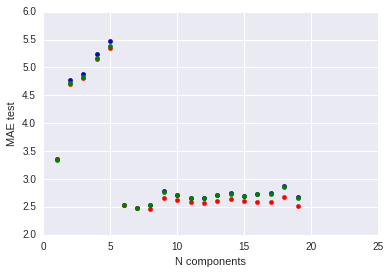

Min MAE 2.48096418849
Min MAE 2.46988698395
Min MAE 2.48428287966


In [260]:
# ACP ne fonctionne bien qu'avec taux de sortie sans bloc
df_train_x, df_train_y, df_test_x, df_test_y = create_train_and_test("taux_sortie_sans_bloc", dft11)
# ACP 
ss = StandardScaler()
df_train_x = ss.fit_transform(df_train_x)
df_test_x = ss.transform(df_test_x)

score = []
score2 = []
score3 = []
for i in range(1, 20):
    pca = PCA(n_components=i)
    pca.fit(df_train_x)
    pca.transform(df_test_x)
    df_train_x_select_features = pca.transform(df_train_x)
    df_test_x_select_features = pca.transform(df_test_x)

    lr = LinearRegression()
    rd = Ridge(100)
    ls = linear_model.Lasso(0.001, normalize=True,random_state=42)
    lr.fit(df_train_x_select_features, df_train_y)
    rd.fit(df_train_x_select_features, df_train_y)
    ls.fit(df_train_x_select_features, df_train_y)
    score.append(metrics.mean_absolute_error(df_test_y, lr.predict(df_test_x_select_features)))
    score2.append(metrics.mean_absolute_error(df_test_y, rd.predict(df_test_x_select_features)))
    score3.append(metrics.mean_absolute_error(df_test_y, ls.predict(df_test_x_select_features)))
    plt.scatter(i, metrics.mean_absolute_error(df_test_y, lr.predict(df_test_x_select_features)))
    plt.scatter(i, metrics.mean_absolute_error(df_test_y, rd.predict(df_test_x_select_features)),color="r")
    plt.scatter(i, metrics.mean_absolute_error(df_test_y, ls.predict(df_test_x_select_features)),color="g")
    
plt.xlabel("N components")
plt.ylabel("MAE test")
plt.show()
print("Min MAE %s" % min(score))
print("Min MAE %s" % min(score2))
print("Min MAE %s" % min(score3))

In [261]:
# 2.06 sans bloc avec un decision tree
df_train_x, df_train_y, df_test_x, df_test_y = create_train_and_test("taux_sortie_sans_bloc", dft11)

list_keep = ['D?c?s domicili?s par d?partement', 'taux_centre_sup_moyenne',
'taux_droite_sup_moyenne', 'taux_gauche_sup_moyenne',
'taux_xdroite_sup_moyenne', 'pop_centre', 'Dissident',
'conjoncture travaux publics-opinions sur le carnet de commandes',
'densit?_m?decins']
lr = LinearRegression()

df_train_x_select_features = df_train_x.ix[:, list_keep]
df_test_x_select_features = df_test_x.ix[:, list_keep]

lr.fit(df_train_x_select_features, df_train_y)
print(metrics.mean_absolute_error(df_test_y, lr.predict(df_test_x_select_features)))

2.06852944016


## Prédiction Xdroite

In [17]:
svr = linear_model.Lasso(alpha=0.01, normalize=True, max_iter=5000, random_state=42)
target_and_predict("taux_xdroite",dft11, svr, True)

Avec l'estimateur Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=5000,
   normalize=True, positive=False, precompute=False, random_state=42,
   selection='cyclic', tol=0.0001, warm_start=False)
Approche taux_xdroite
Nb itération : 773
MSE test : 24.735884349
MAE test : 4.15097208772
R2 test : -0.269190490869 


Features à garder
-6.02732088033 droite_au_pouvoir
-0.278220374465 taux_droite_sup_moyenne
-0.00101490394711 subventions
0.0205835453482 pop_centre
0.0789344568171 persistance_centre_droite
0.0901915856578 taux_chomage
0.370528357584 capacite epargne future(am?lioration moins deterioration)
0.398855410231 Dissident
0.7793679783 depart_frontalier
2.03336090712 taux_xdroite_sup_moyenne




In [18]:
df_train_x, df_train_y, df_test_x, df_test_y = create_train_and_test("taux_xdroite", dft11)

for i in np.linspace(0.06,0.08,4):
    print(i)
    svr = linear_model.Lasso(alpha=i, normalize=True, max_iter=5000, random_state=42)
    svr.fit(df_train_x, df_train_y)
    print(metrics.mean_absolute_error(df_test_y, svr.predict(df_test_x)))
    print("\n")
    
# Best param = 0.07
svr = linear_model.Lasso(alpha=0.07, normalize=True, max_iter=5000, random_state=42)
target_and_predict("taux_xdroite",dft11, svr, True)
# Conserve seulement 3 variables

0.06
2.82721582747


0.0666666666667
2.7786878123


0.0733333333333
2.7527189425


0.08
2.87747884185


Avec l'estimateur Lasso(alpha=0.07, copy_X=True, fit_intercept=True, max_iter=5000,
   normalize=True, positive=False, precompute=False, random_state=42,
   selection='cyclic', tol=0.0001, warm_start=False)
Approche taux_xdroite
Nb itération : 31
MSE test : 11.6402015673
MAE test : 2.75958798696
R2 test : 0.402744897554 


Features à garder
-0.333602905988 droite_au_pouvoir
-0.00432439878683 subventions
1.23665150143 taux_xdroite_sup_moyenne




In [19]:
df_train_x_select_features = df_train_x.ix[:, ["droite_au_pouvoir","subventions",
                                               "taux_xdroite_sup_moyenne","Dissident"]]
df_test_x_select_features = df_test_x.ix[:, ["droite_au_pouvoir","subventions",
                                               "taux_xdroite_sup_moyenne","Dissident"]]

svr.fit(df_train_x_select_features, df_train_y)
print(metrics.mean_absolute_error(df_test_y, svr.predict(df_test_x_select_features)))

2.75972083546


In [20]:
for i in np.linspace(0.07,0.11,8):
    my_Lslasso(dft11,"taux_xdroite", i)
    print("\n")

0.07
Index(['taux_xdroite_sup_moyenne', 'droite_au_pouvoir', 'subventions'], dtype='object')
R2 train 0.876332493133
MAE test 3.79294777677


0.0757142857143
Index(['taux_xdroite_sup_moyenne', 'subventions'], dtype='object')
R2 train 0.849593597988
MAE test 2.35596459323


0.0814285714286
Index(['taux_xdroite_sup_moyenne', 'subventions'], dtype='object')
R2 train 0.849593597988
MAE test 2.35596459323


0.0871428571429
Index(['taux_xdroite_sup_moyenne', 'subventions'], dtype='object')
R2 train 0.849593597988
MAE test 2.35596459323


0.0928571428571
Index(['taux_xdroite_sup_moyenne', 'subventions'], dtype='object')
R2 train 0.849593597988
MAE test 2.35596459323


0.0985714285714
Index(['taux_xdroite_sup_moyenne', 'subventions'], dtype='object')
R2 train 0.849593597988
MAE test 2.35596459323


0.104285714286
Index(['taux_xdroite_sup_moyenne', 'subventions'], dtype='object')
R2 train 0.849593597988
MAE test 2.35596459323


0.11
Index(['taux_xdroite_sup_moyenne', 'subventions'], dtype='obje

In [21]:
for i in [0.1,0.5]:
    for j in np.linspace(0,1,11):
        my_LsElasticNet(dft11, "taux_xdroite",i, j)

Alpha value 0.1
Ratio 0.0


/home/brehelin/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/home/brehelin/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


L'itération n'a pas convergé
1.50599647933e+14
Alpha value 0.1
Ratio 0.1
2.25895191063e+13
Alpha value 0.1
Ratio 0.2
6.68012709085e+13
Alpha value 0.1
Ratio 0.3
1.40414780593e+13
Alpha value 0.1
Ratio 0.4
8.66646665398e+12
Alpha value 0.1
Ratio 0.5
8.43914986397e+13
Alpha value 0.1
Ratio 0.6
4.93495576501e+13
Alpha value 0.1
Ratio 0.7
9.02395068475e+12
Alpha value 0.1
Ratio 0.8
5.12681210678e+12
Alpha value 0.1
Ratio 0.9
1.2462126971e+13
Alpha value 0.1
Ratio 1.0
2.35596459323
Alpha value 0.5
Ratio 0.0
L'itération n'a pas convergé
1.50599647933e+14
Alpha value 0.5
Ratio 0.1
8.66646665398e+12
Alpha value 0.5
Ratio 0.2
5.12211128707e+13
Alpha value 0.5
Ratio 0.3
1.99820341298e+13
Alpha value 0.5
Ratio 0.4
8.01748829624
Alpha value 0.5
Ratio 0.5
4.00362228673
Alpha value 0.5
Ratio 0.6
Tout les coéfficients sont nuls
Alpha value 0.5
Ratio 0.7
Tout les coéfficients sont nuls
Alpha value 0.5
Ratio 0.8
Tout les coéfficients sont nuls
Alpha value 0.5
Ratio 0.9
Tout les coéfficients sont nuls
A

Après tentative de sélection par lasso, lsLasso, et lsElasticNet:  
Le modèle le plus performant est 'taux_xdroite_sup_moyenne', 'subventions' avec alpha = 0.1  
*On obtient une MAE à 2.35*

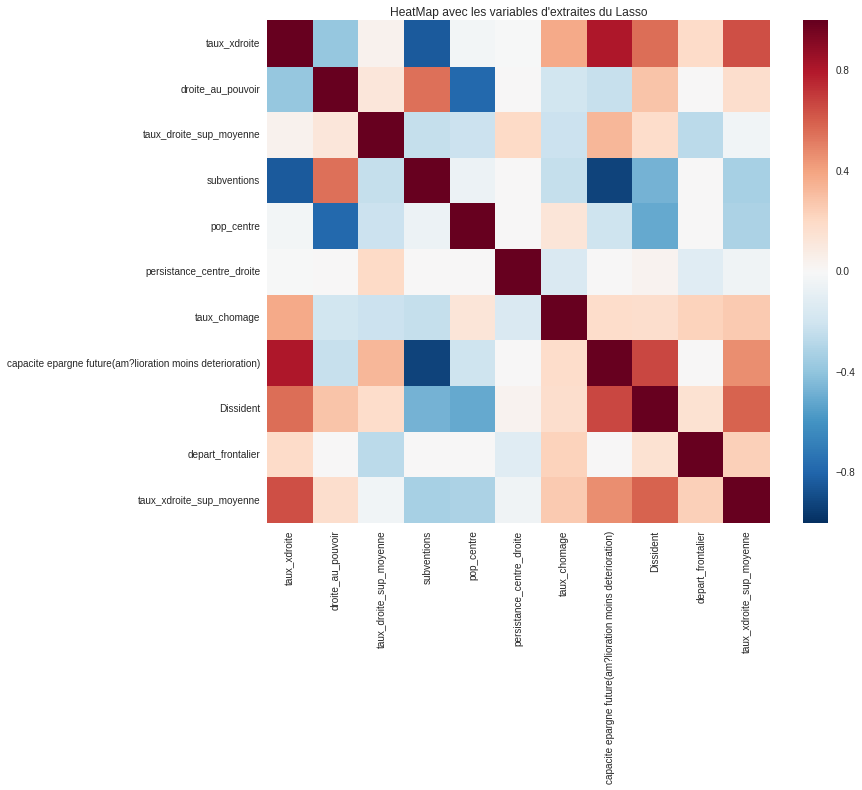

In [173]:
liste_features = ["taux_xdroite","droite_au_pouvoir","taux_droite_sup_moyenne","subventions","pop_centre",
                 "persistance_centre_droite","taux_chomage","capacite epargne future(am?lioration moins deterioration)",
                 "Dissident","depart_frontalier","taux_xdroite_sup_moyenne"]
xdroite_mat = dft11.ix[:, liste_features].corr()
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))
# Draw the heatmap using seaborn
sns.heatmap(xdroite_mat, vmax=1, square=True)
plt.title("HeatMap avec les variables d'extraites du Lasso")
plt.show()

In [184]:
# Corrélation significative
print(pearsonr(dft11.ix[:, "subventions"], dft11.ix[:, "taux_xdroite"]))
print(spearmanr(dft11.ix[:, "subventions"], dft11.ix[:, "taux_xdroite"]))
print(pearsonr(dft11.ix[:, "capacite epargne future(am?lioration moins deterioration)"], dft11.ix[:, "taux_xdroite"]))
print(spearmanr(dft11.ix[:, "capacite epargne future(am?lioration moins deterioration)"], dft11.ix[:, "taux_xdroite"]))

(-0.84013165537400447, 1.227717388682091e-154)
SpearmanrResult(correlation=-0.75433624492940221, pvalue=5.4005301614771731e-107)
(0.8118589685271328, 2.9573019470585734e-136)
SpearmanrResult(correlation=0.63771037945936282, pvalue=4.4840183388346038e-67)


In [43]:
print(pearsonr(dft11.ix[:, "taux_bdroite"], dft11.ix[:, "taux_xdroite"]))
print(spearmanr(dft11.ix[:, "taux_bdroite"], dft11.ix[:, "taux_xdroite"]))
print("\n")
print(pearsonr(dft11.ix[:, "taux_bgauche"], dft11.ix[:, "taux_xdroite"]))
print(spearmanr(dft11.ix[:, "taux_bgauche"], dft11.ix[:, "taux_xdroite"]))

(-0.59582438975884333, 1.225067734075299e-56)
SpearmanrResult(correlation=-0.6263621171933339, pvalue=4.3357982416088859e-64)


(-0.38911000369492599, 2.916719686761421e-22)
SpearmanrResult(correlation=-0.34286688601877469, pvalue=2.4754580747047025e-17)


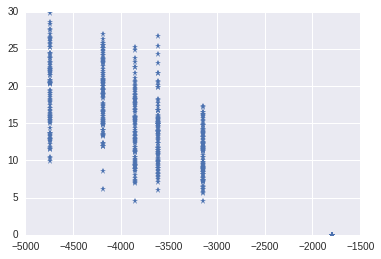

In [200]:
plt.plot(dft11.ix[:, "subventions"], dft11.ix[:, "taux_xdroite"],"*")
plt.show()

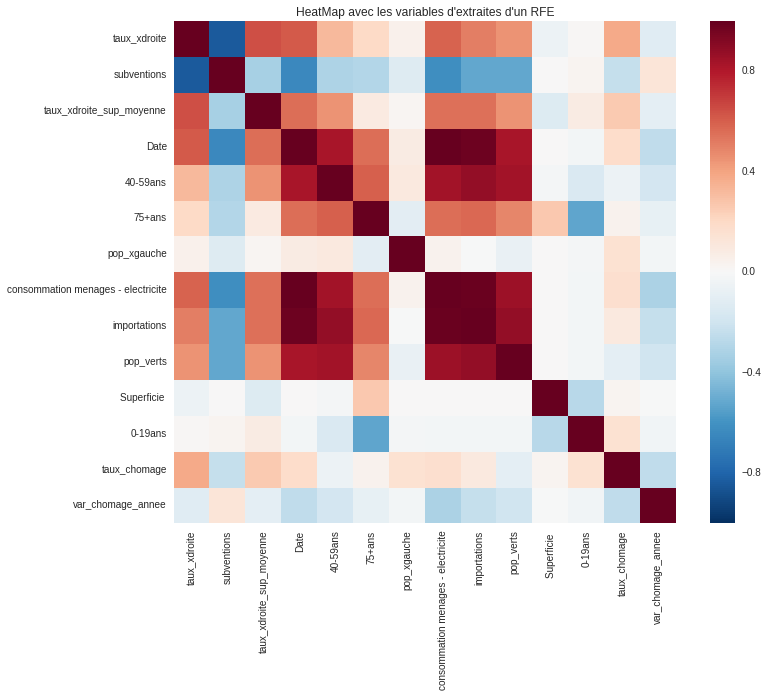

In [171]:
liste_features = ["taux_xdroite",'subventions', "taux_xdroite_sup_moyenne",'Date',
                 '40-59ans','75+ans','pop_xgauche','consommation menages - electricite',
                 'importations','pop_verts','Superficie ','0-19ans',"taux_chomage","var_chomage_annee"]
xdroite_mat = dft11.ix[:, liste_features].corr()
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))
# Draw the heatmap using seaborn
sns.heatmap(xdroite_mat, vmax=1, square=True)
plt.title("HeatMap avec les variables d'extraites d'un RFE")
plt.show()

Subvention est trop corrélé à la cible et est donc très colléré à nos variables discriminante
l'ajout de variable n'améliore pas le modèle
par ailleurs supprimer subvention pourrie notre modèle
#### Suppression de l'année 1981 pour le fn

In [160]:
svr = linear_model.Lasso(alpha=0.01, normalize=True, max_iter=5000, random_state=42)
target_and_predict("taux_xdroite",dft11, svr, True, True)
# Amélioration avec la supprésion de l'année 1981 4.15 vs 3.58

Avec l'estimateur Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=5000,
   normalize=True, positive=False, precompute=False, random_state=42,
   selection='cyclic', tol=0.0001, warm_start=False)
Approche taux_xdroite
Nb itération : 43
MSE test : 18.4691074105
MAE test : 3.58552089177
R2 test : 0.0523558741824 


Features à garder
-1.30301041402 droite_au_pouvoir
-0.592450932135 taux_droite_sup_moyenne
-0.390249413703 persistance centre
-0.385217577924 taux_gauche_sup_moyenne
-0.174121565646 taux_vert_sup_moyenne
-0.00395118511092 subventions
-9.07831246726e-05 Densit?
0.00533140314588 pop_president
0.136060373001 persistance_centre_droite
1.1450635804 depart_frontalier
1.65566780753 taux_xdroite_sup_moyenne
7.58960826692 Nombre total de mariages domicili?s




In [44]:
for i in [0.01, 0.1,0.2]:
    my_Lslasso(dft11,"taux_xdroite", i, True)
    print("\n")

0.01
Index(['depart_frontalier', 'Nombre total de mariages domicili?s',
       'taux_droite_sup_moyenne', 'taux_gauche_sup_moyenne',
       'taux_vert_sup_moyenne', 'taux_xdroite_sup_moyenne', 'pop_president',
       'droite_au_pouvoir', 'Densit?', 'persistance centre',
       'persistance_centre_droite', 'subventions'],
      dtype='object')
R2 train 0.768032668087
MAE test 3.88253256098


0.1
Index(['taux_xdroite_sup_moyenne', 'subventions'], dtype='object')
R2 train 0.614531693101
MAE test 2.30368315506


0.2
Index([], dtype='object')
Tout les coéfficients sont nuls




In [57]:
# Création new variable
df_train_x, df_train_y, df_test_x, df_test_y = create_train_and_test("taux_xdroite", dft11, option_fn=True)

In [65]:
model = LinearRegression()
ss = StandardScaler()

df_train_x_select_features = df_train_x.ix[:, ["subventions",
                                               "taux_xdroite_sup_moyenne"]]
df_test_x_select_features = df_test_x.ix[:, ["subventions",
                                               "taux_xdroite_sup_moyenne"]]
df_train_x_select_features = ss.fit_transform(df_train_x_select_features)
df_test_x_select_features = ss.transform(df_test_x_select_features)

model.fit(df_train_x_select_features, df_train_y)
print(metrics.mean_absolute_error(df_test_y, model.predict(df_test_x_select_features)))

2.30368315506


In [66]:
np.mean(model.predict(df_test_x_select_features))

19.343900573346186

In [35]:
# Analyse sans normaliser les données
svr = linear_model.Lasso(alpha=0.8, normalize=False, max_iter=5000, random_state=42)
target_and_predict("taux_xdroite",dft11, svr, True, True)
# Sans normaliser encore plus performant

Avec l'estimateur Lasso(alpha=0.8, copy_X=True, fit_intercept=True, max_iter=5000,
   normalize=False, positive=False, precompute=False, random_state=42,
   selection='cyclic', tol=0.0001, warm_start=False)
Approche taux_xdroite
Nb itération : 2573
MSE test : 10.3632817004
MAE test : 2.72823289051
R2 test : 0.468263256623 


Features à garder
-0.231598709707 taux_droite_sup_moyenne
-0.00504241197113 subventions
-0.000452981109736 Densit?
-0.000359320463023 Superficie 
-0.000202734325943 consommation menages - electricite
2.90254064024e-06 0-19ans
8.76729260297e-05 importations
0.0136742286915 densit?_m?decins
1.7058732295 taux_xdroite_sup_moyenne




In [162]:
# Teste LsLasso sans normaliser et sans 1981
for i in np.linspace(0.6, 1.5, 10):
    my_Lslasso(dft11,"taux_xdroite", i, True, False)
    print("\n")

0.6
Index(['0-19ans', '60-74ans', 'taux_chomage', 'taux_droite_sup_moyenne',
       'taux_gauche_sup_moyenne', 'taux_xdroite_sup_moyenne', 'Superficie ',
       'Densit?', 'importations', 'subventions', 'densit?_m?decins',
       'consommation menages - electricite'],
      dtype='object')
R2 train 0.756247067354
MAE test 3.09157466417


0.7
Index(['0-19ans', '60-74ans', 'taux_droite_sup_moyenne',
       'taux_gauche_sup_moyenne', 'taux_xdroite_sup_moyenne', 'Superficie ',
       'Densit?', 'importations', 'subventions', 'densit?_m?decins',
       'consommation menages - electricite'],
      dtype='object')
R2 train 0.753039565106
MAE test 3.35297440708


0.8
Index(['0-19ans', 'taux_droite_sup_moyenne', 'taux_xdroite_sup_moyenne',
       'Superficie ', 'Densit?', 'importations', 'subventions',
       'densit?_m?decins', 'consommation menages - electricite'],
      dtype='object')
R2 train 0.734257830312
MAE test 2.97365018862


0.9
Index(['0-19ans', 'taux_droite_sup_moyenne', 'taux_xdr

In [60]:
#df_train_x, df_train_y, df_test_x, df_test_y = create_train_and_test("taux_xdroite", dft11)
#skb = SelectKBest(f_regression, k=10)
#skb.fit(df_train_x, df_train_y)
#skb_result = sorted(zip(skb.scores_, skb.pvalues_ ,df_train_x.columns))

#[ print(skb_result[i]) for i in skb.get_support(True)]

In [61]:
#sfm = SelectFromModel(svc, threshold=0.4)
#sfm.fit(df_train_x, df_train_y)
#print(df_train_x.columns[sfm.get_support(True)])
#print("\n")
#dtr = DecisionTreeRegressor()
#sfm = SelectFromModel(dtr, threshold=0.1)
#sfm.fit(df_train_x, df_train_y)
#print(df_train_x.columns[sfm.get_support(True)])

In [114]:
df_train_x, df_train_y, df_test_x, df_test_y = create_train_and_test("taux_xdroite", dft11, True)

mat_cor = pd.concat([df_train_x, df_train_y], axis=1)



xdroite_corr = pd.DataFrame(columns=["name","corr_pearson",
                                    "corr_pearson_pvalue","corr_spearman",
                                    "corr_sperman_pvalue"])
for i in range(1, mat_cor.shape[1]):
    xdroite_corr = xdroite_corr.append(
        {"name" : mat_cor.columns[i],
        "corr_pearson": pearsonr(mat_cor.ix[:, i], mat_cor.ix[:, "taux_xdroite"])[0],
        "corr_pearson_pvalue": round(pearsonr(mat_cor.ix[:, i], mat_cor.ix[:, "taux_xdroite"])[1], 5),
        "corr_spearman": spearmanr(mat_cor.ix[:, i], mat_cor.ix[:, "taux_xdroite"])[0],
        "corr_sperman_pvalue": round(spearmanr(mat_cor.ix[:, i], mat_cor.ix[:, "taux_xdroite"])[1], 5),
       },
        ignore_index=True
        )

In [115]:
# On conserve les variables qui sont pertinante sur les deux tests
# les pvalues sont équivalentes que les variables soit centré-réduite ou non
# on peut donc trier nos data 
xdroite_corr2 = xdroite_corr[(xdroite_corr["corr_sperman_pvalue"]<=0.05) 
                             & (xdroite_corr["corr_pearson_pvalue"]<=0.05)]
# Il nous reste 27 features
# plus besoin des pvalues puisque l'on à vérifié la condition de rejet sur h0
del xdroite_corr2["corr_sperman_pvalue"]
del xdroite_corr2["corr_pearson_pvalue"]

In [120]:
xdroite_var_select = xdroite_corr2[(xdroite_corr2["corr_spearman"]>=0.25)|(xdroite_corr2["corr_spearman"]<=-0.25)]

In [127]:
# Il faut maintenant choisir les variables à selectionner 
# Cad garder des variables discriminantes et non corrélée 
mat_cor.ix[:, xdroite_var_select["name"]].corr()

# VOIR SI ON FAIT DES TEST SUR CES CORRELATIONS 

,75+ans,Naissances domicili?es par d?partement,Nombre total de mariages domicili?s,var_chomage_annee,taux_droite_sup_moyenne,taux_gauche_sup_moyenne,taux_xdroite_sup_moyenne,pop_premier_ministre,pop_president,droite_au_pouvoir,subventions,conjoncture travaux publics-opinions sur le carnet de commandes,capacit? epargne actuelle (augmentation moins diminution),ecart_pop,taux_xdroite
75+ans,1.000000,-0.753347,-0.642176,-0.239744,0.335655,0.238875,-0.139887,-0.254980,-0.272661,0.384096,0.097217,0.317507,-0.044681,-0.001766,-0.309579
Naissances domicili?es par d?partement,-0.753347,1.000000,0.771570,0.117573,-0.217575,-0.195551,0.240248,-0.146631,0.177201,-0.025635,0.035438,0.147122,-0.150887,0.198456,0.219648
Nombre total de mariages domicili?s,-0.642176,0.771570,1.000000,0.256451,-0.204259,-0.174548,0.197773,-0.194597,0.291172,-0.210789,-0.202308,-0.060075,0.079106,0.296823,0.378712
var_chomage_annee,-0.239744,0.117573,0.256451,1.000000,-0.102846,-0.101257,-0.188730,-0.223255,0.658536,-0.674506,-0.602750,-0.459092,0.397543,0.534323,0.352662
taux_droite_sup_moyenne,0.335655,-0.217575,-0.204259,-0.102846,1.000000,-0.123916,-0.202847,-0.080461,-0.228581,0.223699,0.034489,0.110335,0.045342,-0.085686,-0.380840
taux_gauche_sup_moyenne,0.238875,-0.195551,-0.174548,-0.101257,-0.123916,1.000000,-0.196595,-0.061659,-0.225089,0.203783,0.021339,0.081588,0.063414,-0.095477,-0.278296
taux_xdroite_sup_moyenne,-0.139887,0.240248,0.197773,-0.188730,-0.202847,-0.196595,1.000000,-0.143109,-0.336430,0.340857,0.047499,0.179116,0.066020,-0.110520,0.512363
pop_premier_ministre,-0.254980,-0.146631,-0.194597,-0.223255,-0.080461,-0.061659,-0.143109,1.000000,-0.323738,-0.076554,0.433339,-0.357766,-0.193273,-0.825051,-0.260563
pop_president,-0.272661,0.177201,0.291172,0.658536,-0.228581,-0.225089,-0.336430,-0.323738,1.000000,-0.821317,-0.531747,-0.320585,0.138139,0.801728,0.328749
droite_au_pouvoir,0.384096,-0.025635,-0.210789,-0.674506,0.223699,0.203783,0.340857,-0.076554,-0.821317,1.000000,0.689865,0.797893,-0.487832,-0.442148,-0.402990


### Prédiction Abstentions

In [17]:
svr = linear_model.Lasso(alpha=0.01, normalize=True, max_iter=5000, random_state=42)
target_and_predict("taux_Abstention",dft11, svr)

Avec l'estimateur Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=5000,
   normalize=True, positive=False, precompute=False, random_state=42,
   selection='cyclic', tol=0.0001, warm_start=False)
Approche taux_Abstention
Nb itération : 93
MSE test : 112.694479718
MAE test : 10.2677466824
R2 test : -6.30769066886 




In [41]:
for i in [0.00001,0.0001,0.001,0.01]:
    my_Lslasso(dft11,"taux_Abstention", i, option_fn=True, normalize=True, max_iter=20000)
    print("\n")

1e-05
Index(['depart_frontalier', '0-19ans', '20-39ans', '40-59ans', '60-74ans',
       '75+ans', 'Naissances domicili?es par d?partement',
       'Nombre total de mariages domicili?s',
       'D?c?s domicili?s par d?partement', 'var_chomage_annee', 'taux_chomage',
       'taux_centre_sup_moyenne', 'taux_droite_sup_moyenne',
       'taux_gauche_sup_moyenne', 'taux_vert_sup_moyenne',
       'taux_xdroite_sup_moyenne', 'taux_xgauche_sup_moyenne', 'pop_xgauche',
       'pop_premier_ministre', 'cohabitation', 'pop_president',
       'droite_au_pouvoir', 'Dissident', 'Superficie ', 'Densit?',
       'persistance_gauche', 'persistance_droite', 'persistance centre',
       'persistance_centre_droite', 'pres_centre', 'pres_droite',
       'pres_gauche', 'pres_xgauche', 'subventions',
       'capacit? epargne actuelle (augmentation moins diminution)',
       'capacite epargne future(am?lioration moins deterioration)',
       'densit?_m?decins', 'CORS88', 'CORS02'],
      dtype='object')
R2 trai

## Plusieurs test

In [37]:
#Export de la table de train pour un prune d'arbre sur R
#df_export = pd.concat([df_train_x, df_train_y], axis=1)
df_train.to_csv("base_train_gauche.csv",index=False)

df_export = pd.concat([df_test_x, df_test_y], axis=1)
df_test.to_csv("base_test_gauche.csv",index=False)

In [19]:
name_columns = df_train_x.columns

In [10]:
#ss = StandardScaler()
#df_train_x = ss.fit_transform(df_train_x)
#df_test_x = ss.transform(df_test_x)

In [11]:
svr = LinearSVR()
svr.fit(df_train_x, df_train_y)
print(metrics.mean_squared_error(df_test_y, svr.predict(df_test_x)))
print(metrics.mean_absolute_error(df_test_y, svr.predict(df_test_x)))

svr.score(df_test_x, df_test_y)

3.95304008746
1.41192195687


0.88042516497972223

In [23]:
svr = LinearRegression()
svr.fit(df_train_x, df_train_y)
print("MSE test : %s" % metrics.mean_squared_error(df_test_y, svr.predict(df_test_x)))
print("MAE test : %s" % metrics.mean_absolute_error(df_test_y, svr.predict(df_test_x)))

for i in range(len(svr.coef_)):
    print(svr.coef_[i], df_train.drop("taux_gauche", axis=1).columns[i])

print("R2 test : %s " % svr.score(df_test_x, df_test_y))


MSE test : 793.892404365
MAE test : 28.1199629059
-0.31789826163 d?partement
0.97874980605 Ann?e
-2.20846262682e-06 depart_frontalier
-0.437363636241 depart_CORSE
-0.502511083024 0-19ans
-0.205205864103 20-39ans
-0.151775572621 40-59ans
0.784499783161 60-74ans
0.49011714813 75+ans
-0.828691563529 Naissances domicili?es par d?partement
-0.294112719774 Nombre total de mariages domicili?s
-0.163843216722 D?c?s domicili?s par d?partement
-0.15305605254 var_chomage_annee
-0.240554829473 taux_chomage
0.58144255953 taux_centre_sup_moyenne
-0.080280734876 taux_droite_sup_moyenne
-0.195653739041 taux_gauche_sup_moyenne
-0.333630592432 taux_vert_sup_moyenne
0.184437760506 taux_xdroite_sup_moyenne
-0.201821450007 taux_xgauche_sup_moyenne
-0.000295455871121 taux_Abstention_sup_moyenne
0.000945128653329 taux_Blancs et nuls_sup_moyenne
-0.00684895376797 pop_verts
0.00700923788425 pop_centre
-0.00534204686138 pop_droite
-0.0136065755798 pop_gauche
-0.0136262296689 pop_xdroite
-0.000901648856203 pop_x

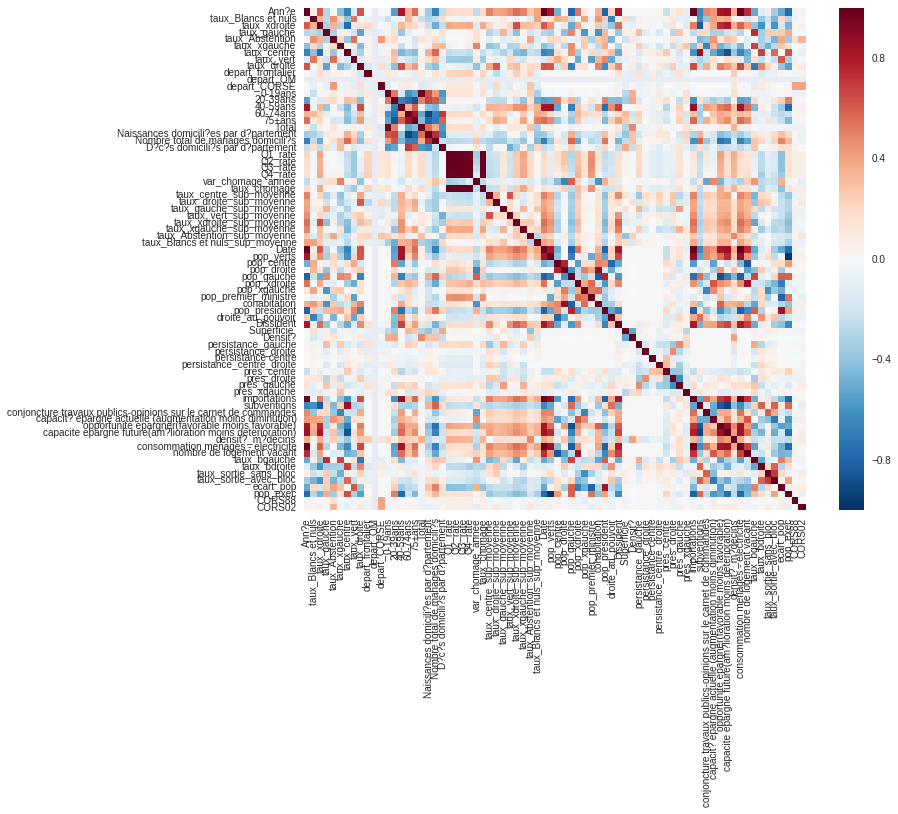

In [28]:
corrmat = dft11.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=1, square=True)
plt.show()

In [24]:
Counter(df_train["pop_president"])

Counter({25: 96, 38: 96, 50: 96, 58: 96})

In [14]:
# df_train_x1 = df_train_x[["var_chomage_annee", "taux_gauche_sup_moyenne", "40-59ans"]]
# df_test_x1 = df_test_x[["var_chomage_annee", "taux_gauche_sup_moyenne", "40-59ans"]]
# print(df_test_x1.shape, df_train_x1.shape)
X = sm.add_constant(df_train_x)
X_test = sm.add_constant(df_test_x)

model = sm.OLS(df_train_y, X)
results = model.fit()
print(metrics.r2_score(results.predict(X_test), df_test_y))

#print(metrics.r2_score(model.predict(df_test_x), df_test_y))
print(results.summary())

0.881263171063
                            OLS Regression Results                            
Dep. Variable:            taux_gauche   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     83.74
Date:                Fri, 24 Mar 2017   Prob (F-statistic):          1.22e-147
Time:                        16:07:53   Log-Likelihood:                -785.88
No. Observations:                 384   AIC:                             1644.
Df Residuals:                     348   BIC:                             1786.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         26.5437      0.100    2

In [70]:
svr = DecisionTreeRegressor(max_depth=6, min_samples_leaf=10)
svr.fit(df_train_x, df_train_y)
print(metrics.mean_squared_error(df_test_y, svr.predict(df_test_x)))
print(metrics.mean_absolute_error(df_test_y, svr.predict(df_test_x)))
print(metrics.r2_score(df_test_y, svr.predict(df_test_x)))
print("\n")
for i in range(len(svr.feature_importances_)):
    print(svr.feature_importances_[i], df_train.drop("taux_gauche", axis=1).columns[i])



18.6874038783
3.5455792847
-0.0190038616276


0.0 département
0.0 Année
0.0 depart_frontalier
0.0 depart_CORSE
0.00101966709785 0-19ans
0.0 20-39ans
0.0 40-59ans
0.00707695465992 60-74ans
0.00198005078727 75+ans
0.0 Naissances domiciliées par département
0.00948809506211 Nombre total de mariages domiciliés
0.0 Décès domiciliés par département
0.00478662267849 var_chomage_annee
0.0 taux_chomage
0.185276146829 taux_centre_sup_moyenne
0.0 taux_droite_sup_moyenne
0.0120323229971 taux_gauche_sup_moyenne
0.00754492730986 taux_vert_sup_moyenne
0.0 taux_xdroite_sup_moyenne
0.00790742707964 taux_xgauche_sup_moyenne
0.0 taux_Abstention_sup_moyenne
0.0 taux_Blancs et nuls_sup_moyenne
0.0 pop_centre
0.0 pop_droite
0.0 pop_gauche
0.00334198100824 pop_xdroite
0.0 pop_xgauche
0.632393604329 pop_premier_ministre
0.0 cohabitation
0.0831879152264 pop_president
0.0123979395566 droite_au_pouvoir
0.00624219153921 Dissident
0.00785856439627 Superficie 
0.0 Densité
0.0 persistance_gauche
0.0 persistance_droi

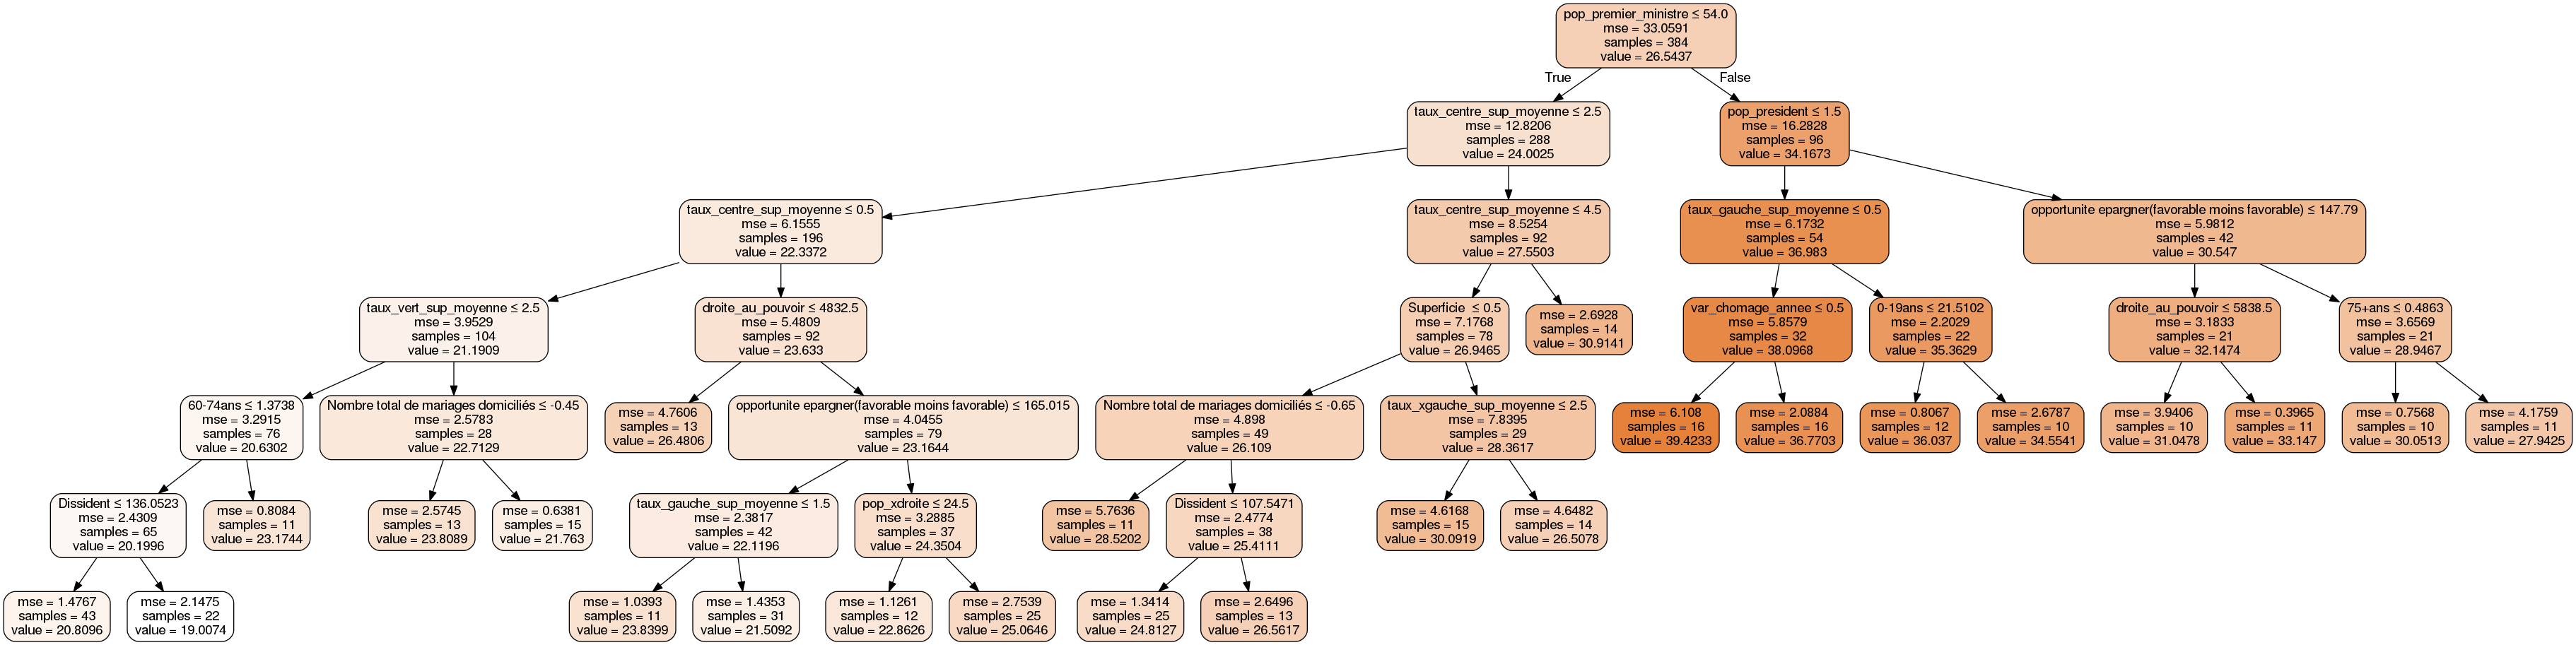

In [71]:
dot_data = tree.export_graphviz(svr, out_file=None,
                         feature_names=name_columns,    
                         filled=True, rounded=True,  
                         special_characters=True)  

graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [12]:
graph.write_pdf("decision_tree_split5.pdf")

True

In [15]:
df_train.columns

Index(['d?partement', 'Ann?e', 'taux_gauche', 'depart_frontalier',
       'depart_CORSE', '0-19ans', '20-39ans', '40-59ans', '60-74ans', '75+ans',
       'Naissances domicili?es par d?partement',
       'Nombre total de mariages domicili?s',
       'D?c?s domicili?s par d?partement', 'var_chomage_annee', 'taux_chomage',
       'taux_centre_sup_moyenne', 'taux_droite_sup_moyenne',
       'taux_gauche_sup_moyenne', 'taux_vert_sup_moyenne',
       'taux_xdroite_sup_moyenne', 'taux_xgauche_sup_moyenne',
       'taux_Abstention_sup_moyenne', 'taux_Blancs et nuls_sup_moyenne',
       'pop_centre', 'pop_droite', 'pop_gauche', 'pop_xgauche',
       'pop_premier_ministre', 'cohabitation', 'pop_president',
       'droite_au_pouvoir', 'Dissident', 'Superficie ', 'Densit?',
       'persistance_gauche', 'persistance_droite', 'persistance centre',
       'persistance_centre_droite', 'pres_centre', 'pres_droite',
       'pres_gauche', 'pres_xgauche', 'importations', 'subventions',
       'conjoncture

In [42]:
liste_drop = ["taux_sortie_sans_bloc","taux_sortie_avec_bloc","taux_bgauche","Ann?e","d?partement","taux_gauche"]
df_train_x = df_train.drop(liste_drop, axis=1)
df_train_y = df_train["taux_sortie_sans_bloc"]
df_test_x = df_test.drop(liste_drop, axis=1)
df_test_y = df_test["taux_sortie_sans_bloc"]

In [24]:
svr = linear_model.Lasso(alpha=0.01)

svr.fit(df_train_x, df_train_y)
print(metrics.mean_squared_error(df_test_y, svr.predict(df_test_x)))
print(metrics.mean_absolute_error(df_test_y, svr.predict(df_test_x)))
print(metrics.r2_score(df_test_y, svr.predict(df_test_x)))

for i in range(len(svr.coef_)):
    print(svr.coef_[i], df_test_x.columns[i])
    
print(svr.score(df_test_x, df_test_y))

62.5220152214
7.71689575845
-2.40925766694
-0.325380938227 depart_frontalier
0.0 depart_CORSE
-2.14384078419e-06 0-19ans
-0.344319019793 20-39ans
-0.458340809078 40-59ans
-0.212506496817 60-74ans
-0.179703733211 75+ans
0.0 Naissances domicili?es par d?partement
0.0 Nombre total de mariages domicili?s
-0.0 D?c?s domicili?s par d?partement
-0.0836317546605 var_chomage_annee
-0.0925629701297 taux_chomage
-0.146443265677 taux_centre_sup_moyenne
-0.174229903904 taux_droite_sup_moyenne
0.601319216407 taux_gauche_sup_moyenne
-0.0539218923109 taux_vert_sup_moyenne
-0.190840954174 taux_xdroite_sup_moyenne
-0.332616627025 taux_xgauche_sup_moyenne
0.180999784909 taux_Abstention_sup_moyenne
-0.186704591334 taux_Blancs et nuls_sup_moyenne
0.0 pop_verts
0.39490523781 pop_centre
0.0 pop_droite
0.0512509669927 pop_gauche
0.0 pop_xdroite
-0.481597171344 pop_xgauche
0.0 pop_premier_ministre
-0.0 cohabitation
0.0363884311202 pop_president
-0.0 droite_au_pouvoir
-0.0313523164968 Dissident
-1.70429144461e-

/home/brehelin/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [58]:
var_importance = SelectKBest(f_regression, k=10).fit_transform(df_train_x, df_train_y)

In [59]:
var_importance.shape

(384, 10)